In [24]:
import pandas as pd
import numpy as np
from time import time
from pprint import PrettyPrinter
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
pp = PrettyPrinter()

# Load

In [25]:
df = pd.read_csv('../data/telco_churn_numeric.csv')

In [30]:
# Seperate Train and Test
target = df['Churn']
train_cols = [col for col in df.columns[1:] if col != 'Churn']
train = df[train_cols]

# Standardize
scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)

In [5]:
def grid_classifier(model, train, target, parameters={}, cv=5, timed=True, feat_imp=False):
    '''
    For tuning models.
    
    Automatically plots CV results, but this requires training over on parameter at a time.
    If the parameters argument stays an empty dictionary then no plot is made (duh...)
    
    Returns the GridSearch object
    
        Parameters:
        -----------
    model - model
    train - array of training data
    target - array of target data
    parameters - dict of parameters the GSearcher will run over
    cv - int, k-fold number
    timed - boolean, gives printout of timings
    
        Returns :
        ---------
    gsearcher - fitted and searched GridSearchCV object
    '''
    if timed:
        start = time()
    
    # Grid Search
    gsearcher = GridSearchCV(
        estimator=model, 
        param_grid=parameters,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        return_train_score=True
    )
    gsearcher.fit(train, target)
    results = gsearcher.cv_results_
    
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')

    # Print Report
    print('Grid Scores: \n')
    pp.pprint(results)
    print(f'Best Model Parameters: {gsearcher.best_params_}')
    print(f'Best Model Score: {gsearcher.best_score_:.4f}')
    
    # Plot CV Results
    if parameters:
        test_means = results['mean_test_score']
        train_means = results['mean_train_score']
        x = range(len(test_means))
        model_name = str(model.__class__).split('.')[-1][:-2]
        param = list(results['params'][0].keys())[0]
        labels = [str(pair[param]) for pair in results['params']]

        plt.figure(figsize=(10, 8))
        plt.plot(x, test_means, label='Test', color='blue')
        plt.plot(x, train_means, label='Train', color='green')
        plt.title(f'{model_name} over {param}')
        plt.xlabel(param)
        plt.ylabel('AUC Scores')
        plt.xticks(x, labels, rotation=60)
        plt.legend()
    
    # Plot Feature Importance
    if feat_imp:
        best_model = gsearcher.best_estimator_
        best_model.fit(train, target)
        feat_series = pd.Series(best_model.feature_importances_, index=train.columns)
        feat_series.sort_values(ascending=False, inplace=True)

        plt.figure(figsize=(10, 8))
        feat_series.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.xticks(rotation=60)        
    
    return gsearcher

# Modeling

## Tuning

### Naive Bayes

In [32]:
model = GaussianNB()

bayes_gsearch = grid_classifier(model, train, target)

Seconds to fit: 0.29
Grid Scores: 

{'mean_fit_time': array([0.01775775]),
 'mean_score_time': array([0.00575686]),
 'mean_test_score': array([0.82718496]),
 'mean_train_score': array([0.82811899]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.83909427]),
 'split0_train_score': array([0.82509832]),
 'split1_test_score': array([0.83459144]),
 'split1_train_score': array([0.82594531]),
 'split2_test_score': array([0.81991397]),
 'split2_train_score': array([0.83028489]),
 'split3_test_score': array([0.82217572]),
 'split3_train_score': array([0.82983764]),
 'split4_test_score': array([0.82013939]),
 'split4_train_score': array([0.8294288]),
 'std_fit_time': array([0.00412956]),
 'std_score_time': array([0.00186555]),
 'std_test_score': array([0.00805368]),
 'std_train_score': array([0.00215452])}
Best Model Parameters: {}
Best Model Score: 0.8272


---
### Logistic Regression

Seconds to fit: 1.11
Grid Scores: 

{'mean_fit_time': array([0.05286298, 0.05187244, 0.08001099, 0.07385144, 0.07751122,
       0.07977648, 0.07306619]),
 'mean_score_time': array([0.00672526, 0.00269899, 0.00209155, 0.00244498, 0.00239673,
       0.00316515, 0.00223842]),
 'mean_test_score': array([0.83563252, 0.84066665, 0.84423104, 0.84495525, 0.84506182,
       0.84507165, 0.84506959]),
 'mean_train_score': array([0.83739497, 0.84339738, 0.84715813, 0.84802034, 0.84812107,
       0.84813093, 0.84813106]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'C': 0.001},
            {'C': 0.01},
            {'C': 0.1},
            {'C': 1.0},
            {'C': 10.0},
            {'C': 100.0},
            {'C': 1000.0}],
 'rank_test_score': array([7, 6, 5, 4, 3, 1, 2], dtype=int32),
 'split0_test_score': array([0.84831693, 0.854147

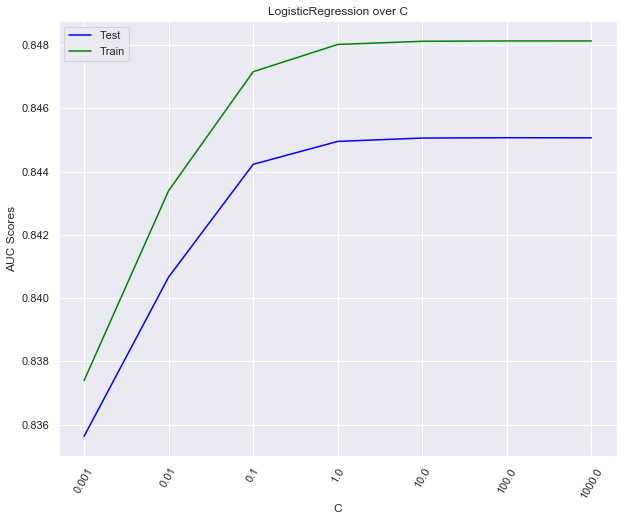

In [33]:
model = LogisticRegression()

parameters = {'C': np.logspace(-3, 3, 7)}

LogReg_gsearch = grid_classifier(model, train, target, parameters)

---
### KNN

Seconds to fit: 90.93
Grid Scores: 

{'mean_fit_time': array([0.04640532, 0.03311024, 0.03776073, 0.03557281, 0.03420181,
       0.03404222, 0.03708611, 0.03528218, 0.03331895, 0.03638015,
       0.03401232, 0.03836222, 0.03154845, 0.03733234, 0.03468695,
       0.03821826, 0.03824558, 0.03636427, 0.03525972]),
 'mean_score_time': array([0.5168087 , 0.55861068, 0.56973166, 0.64224215, 0.62330632,
       0.67023678, 0.67227449, 0.70638366, 0.74001842, 0.73445296,
       0.72788706, 0.72589722, 0.74401116, 0.81111746, 0.78298697,
       0.86628079, 1.01846247, 0.86536317, 0.80635486]),
 'mean_test_score': array([0.79635882, 0.80726628, 0.81345052, 0.81741592, 0.8191279 ,
       0.82022718, 0.82192492, 0.82313781, 0.82472703, 0.82527563,
       0.82581948, 0.82626179, 0.82636639, 0.82646207, 0.82682185,
       0.82642923, 0.82660889, 0.82735636, 0.82728807]),
 'mean_train_score': array([0.86575639, 0.85569962, 0.84943714, 0.84596278, 0.84386459,
       0.84194097, 0.84082808, 0.84024696, 

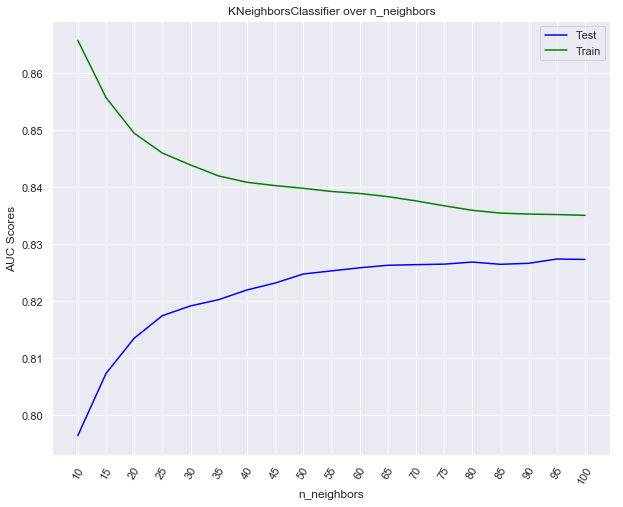

In [34]:
model = KNeighborsClassifier()

parameters = {'n_neighbors': np.arange(10, 101, 5)}

knn_gsearch = grid_classifier(model, train, target, parameters)

---
### Support Vector Machine (RBF Kernel)
Baseline

In [36]:
model = SVC(random_state=42)

svc_rbf_gsearch = grid_classifier(model, train, target)

Seconds to fit: 7.86
Grid Scores: 

{'mean_fit_time': array([2.16453996]),
 'mean_score_time': array([0.28437819]),
 'mean_test_score': array([0.8034792]),
 'mean_train_score': array([0.87910268]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.82810199]),
 'split0_train_score': array([0.87442243]),
 'split1_test_score': array([0.80897466]),
 'split1_train_score': array([0.87712872]),
 'split2_test_score': array([0.77948668]),
 'split2_train_score': array([0.88318216]),
 'split3_test_score': array([0.80662895]),
 'split3_train_score': array([0.88159218]),
 'split4_test_score': array([0.79419055]),
 'split4_train_score': array([0.8791879]),
 'std_fit_time': array([0.48560139]),
 'std_score_time': array([0.06920062]),
 'std_test_score': array([0.01617759]),
 'std_train_score': array([0.00311924])}
Best Model Parameters: {}
Best Model Score: 0.8035


#### C

Seconds to fit: 73.75
Grid Scores: 

{'mean_fit_time': array([2.41636825, 1.70431142, 2.16414313, 1.81393375, 1.9033082 ,
       1.7815731 , 1.82299643, 2.2687953 , 2.24901094, 3.62849655,
       4.655408  , 7.49821472, 7.53105083]),
 'mean_score_time': array([0.26081553, 0.20658817, 0.33983669, 0.27465777, 0.21639123,
       0.23737588, 0.27434902, 0.25211678, 0.19036741, 0.18493853,
       0.17470889, 0.15973625, 0.13426394]),
 'mean_test_score': array([0.82373779, 0.82380677, 0.82384039, 0.82269071, 0.81890008,
       0.80842601, 0.8034792 , 0.78931088, 0.78026917, 0.76004575,
       0.75207442, 0.73974397, 0.73592302]),
 'mean_train_score': array([0.83353805, 0.833789  , 0.83379443, 0.83735923, 0.84280242,
       0.86459152, 0.87910268, 0.92107755, 0.93898315, 0.96854394,
       0.97483405, 0.9825486 , 0.98452505]),
 'param_C': masked_array(data=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0,
                   50.0, 100.0, 500.0, 1000.0],
             mask=[False, False, Fals

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

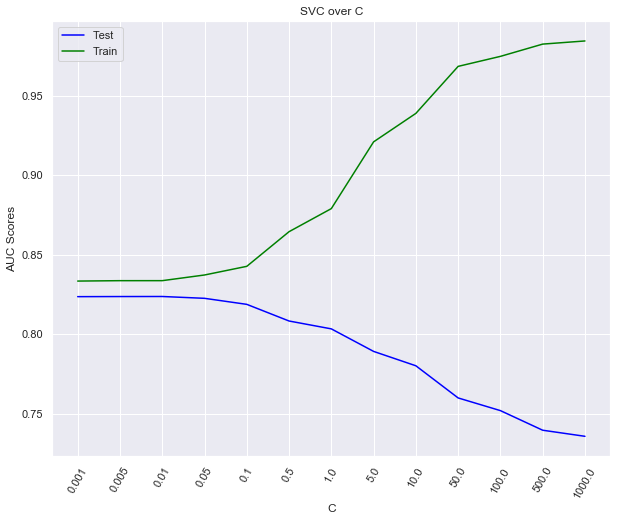

In [35]:
model = SVC(random_state=42)

parameters = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]}

grid_classifier(model, train, target, parameters)

#### Gamma

Seconds to fit: 91.58
Grid Scores: 

{'mean_fit_time': array([2.28021431, 2.07123742, 1.79657335, 1.60524664, 1.86984563,
       2.10432134, 1.87034392, 1.68683205, 1.65631895, 1.66628127,
       1.86922202, 1.85832539, 1.81227412, 1.7503664 , 1.9372251 ,
       2.16341429, 2.12018929, 2.83989844, 2.16597686, 2.19879274,
       1.55451417]),
 'mean_score_time': array([0.27315278, 0.23815985, 0.24237156, 0.25835385, 0.38472481,
       0.27771425, 0.23825941, 0.28654299, 0.27671289, 0.25006022,
       0.23729982, 0.25475025, 0.23817363, 0.28967142, 0.33365126,
       0.43429112, 0.39161706, 0.32891159, 0.24828839, 0.45110989,
       0.2959444 ]),
 'mean_test_score': array([0.83114732, 0.83095644, 0.83038811, 0.82980271, 0.8289231 ,
       0.82778328, 0.82612424, 0.8244904 , 0.82260797, 0.82061806,
       0.8184554 , 0.81639461, 0.81423037, 0.81214798, 0.81042048,
       0.80887098, 0.80730201, 0.80575561, 0.80436642, 0.80311725,
       0.80219949]),
 'mean_train_score': array([0.83391066

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gamma': array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  , 0.105])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

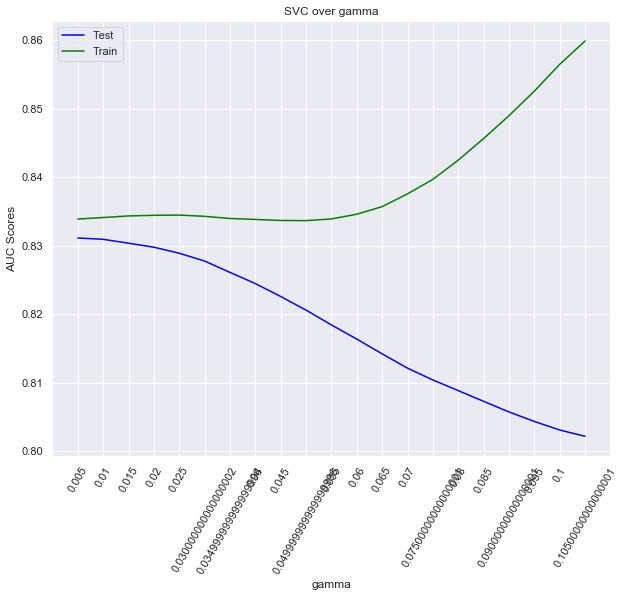

In [78]:
model = SVC(
    random_state=42,
    C=0.01
)

parameters = {'gamma': np.arange(0.005, 0.11, 0.005)}

grid_classifier(model, train, target, parameters)

#### SVC (RBF Kernel) Final Model

In [79]:
model = SVC(
    random_state=42,
    C=0.01,
    gamma=0.005
)

svc_rbf_gsearch = grid_classifier(model, train, target)

Seconds to fit: 6.00
Grid Scores: 

{'mean_fit_time': array([1.68902149]),
 'mean_score_time': array([0.20091662]),
 'mean_test_score': array([0.83114732]),
 'mean_train_score': array([0.83391066]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.84369785]),
 'split0_train_score': array([0.83059849]),
 'split1_test_score': array([0.83514945]),
 'split1_train_score': array([0.8316205]),
 'split2_test_score': array([0.82641375]),
 'split2_train_score': array([0.83567776]),
 'split3_test_score': array([0.83057945]),
 'split3_train_score': array([0.83525863]),
 'split4_test_score': array([0.81988011]),
 'split4_train_score': array([0.83639795]),
 'std_fit_time': array([0.46305804]),
 'std_score_time': array([0.03833775]),
 'std_test_score': array([0.00803895]),
 'std_train_score': array([0.00233844])}
Best Model Parameters: {}
Best Model Score: 0.8311


---
### Support Vector Machine (Polynomial Kernel)

In [44]:
model = SVC(
    random_state=42,
    kernel='poly'
)

grid_classifier(model, train, target)

Seconds to fit: 5.42
Grid Scores: 

{'mean_fit_time': array([1.85614896]),
 'mean_score_time': array([0.12107286]),
 'mean_test_score': array([0.81072043]),
 'mean_train_score': array([0.88285337]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.82400992]),
 'split0_train_score': array([0.87976698]),
 'split1_test_score': array([0.82246764]),
 'split1_train_score': array([0.88069816]),
 'split2_test_score': array([0.79681082]),
 'split2_train_score': array([0.88626629]),
 'split3_test_score': array([0.81255264]),
 'split3_train_score': array([0.88563562]),
 'split4_test_score': array([0.7977427]),
 'split4_train_score': array([0.8818998]),
 'std_fit_time': array([0.59933306]),
 'std_score_time': array([0.02043374]),
 'std_test_score': array([0.01166034]),
 'std_train_score': array([0.0026256])}
Best Model Parameters: {}
Best Model Score: 0.8107


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

#### Degree

Seconds to fit: 22.82
Grid Scores: 

{'mean_fit_time': array([1.81382656, 1.54156032, 2.04275937, 2.19196582, 3.15985498]),
 'mean_score_time': array([0.13256559, 0.13165765, 0.18850145, 0.20070076, 0.32788138]),
 'mean_test_score': array([0.81629362, 0.81072043, 0.78185191, 0.78786347, 0.76540266]),
 'mean_train_score': array([0.83746117, 0.88285337, 0.91336468, 0.93186352, 0.93990721]),
 'param_degree': masked_array(data=[2, 3, 4, 5, 6],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'degree': 2},
            {'degree': 3},
            {'degree': 4},
            {'degree': 5},
            {'degree': 6}],
 'rank_test_score': array([1, 2, 4, 3, 5], dtype=int32),
 'split0_test_score': array([0.84701232, 0.82400992, 0.79521817, 0.79718153, 0.77249219]),
 'split0_train_score': array([0.82995384, 0.87976698, 0.90842835, 0.93023269, 0.93881409]),
 'split1_test_score': array([0.81697796, 0.82246764, 0.78177168, 0.80057609

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'degree': range(2, 7)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

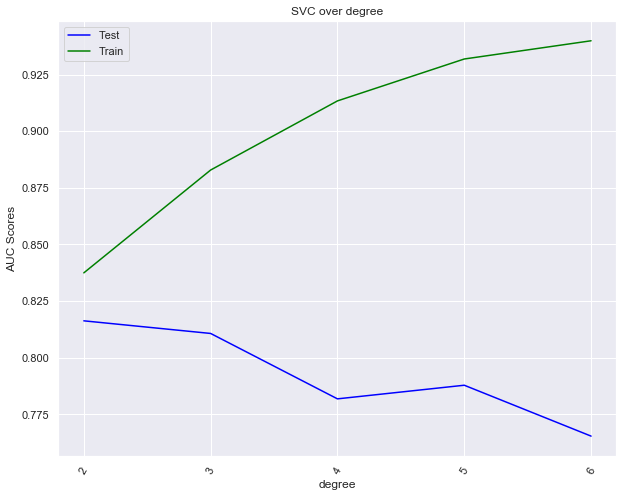

In [48]:
model = SVC(
    random_state=42,
    kernel='poly'
)

parameters = {'degree': range(2, 7)}

grid_classifier(model, train, target, parameters)

#### C

Seconds to fit: 332.71
Grid Scores: 

{'mean_fit_time': array([  1.78899736,   1.88203616,   1.60262766,   1.51080976,
         1.50972137,   1.52625484,   1.60145049,   2.3014586 ,
         3.81136584,   7.311169  ,  14.09413218,  67.45184321,
       111.07512407]),
 'mean_score_time': array([0.17833476, 0.202775  , 0.17561865, 0.20146141, 0.17883286,
       0.1555378 , 0.1350112 , 0.15816712, 0.14783955, 0.137884  ,
       0.13532557, 0.16173663, 0.1015348 ]),
 'mean_test_score': array([0.78710474, 0.78759452, 0.78756435, 0.78760773, 0.79132267,
       0.8115181 , 0.81629362, 0.82056459, 0.82118049, 0.81868837,
       0.81755462, 0.81644139, 0.81621931]),
 'mean_train_score': array([0.80086299, 0.80118962, 0.80113956, 0.80116181, 0.80572687,
       0.83021341, 0.83746117, 0.845536  , 0.846852  , 0.84776966,
       0.84741119, 0.84769418, 0.84805724]),
 'param_C': masked_array(data=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0,
                   50.0, 100.0, 500.0, 1000.0],
   

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

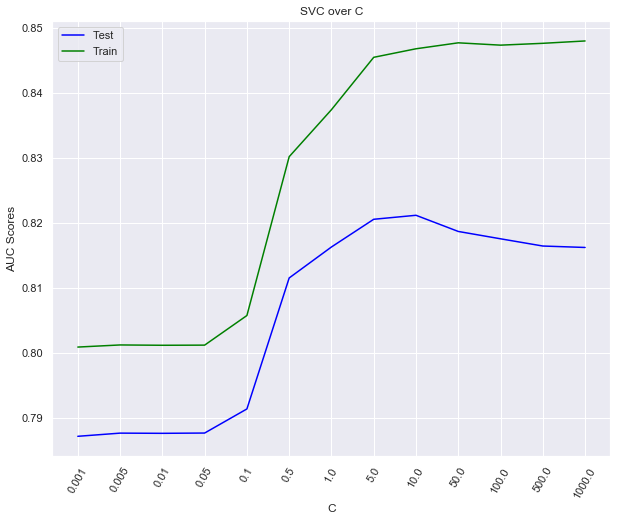

In [51]:
model = SVC(
    random_state=42,
    kernel='poly',
    degree=2
)

parameters = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]}

grid_classifier(model, train, target, parameters)

#### gamma
Sticking with default value of 1/n_feature (1/24 ~ 0.4, which was the gridsearch's favorite)

Seconds to fit: 134.10
Grid Scores: 

{'mean_fit_time': array([1.56268139, 1.39465742, 1.50404487, 1.64778008, 1.88457203,
       2.18300633, 2.30151091, 2.441223  , 3.90689363, 3.9545249 ,
       3.9413816 , 4.58943357, 5.26837964, 5.44479146, 6.48426504,
       6.04076438, 5.82716522, 6.16293197, 6.90384932, 7.28884997,
       7.37535911]),
 'mean_score_time': array([0.15404696, 0.13711743, 0.13021965, 0.13244281, 0.13067622,
       0.13001642, 0.12604213, 0.16576138, 0.16115561, 0.13149781,
       0.15426059, 0.14268975, 0.1844635 , 0.18419914, 0.14497633,
       0.13677063, 0.14712958, 0.13502278, 0.12677193, 0.13887401,
       0.10254183]),
 'mean_test_score': array([0.7963137 , 0.8127776 , 0.81793582, 0.81964539, 0.82055063,
       0.82043644, 0.82085243, 0.82099283, 0.82090134, 0.82073532,
       0.82046601, 0.81998565, 0.81964533, 0.81932386, 0.81910789,
       0.81884437, 0.81875177, 0.81871077, 0.81869774, 0.81864032,
       0.8184746 ]),
 'mean_train_score': array([0.8115287

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gamma': array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  , 0.105])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

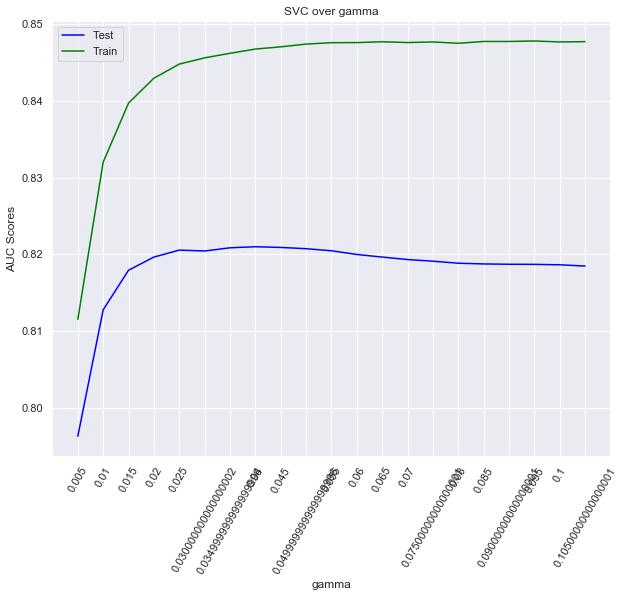

In [77]:
model = SVC(
    random_state=42,
    kernel='poly',
    degree=2,
    C=10
)

parameters = {'gamma': np.arange(0.005, 0.11, 0.005)}

grid_classifier(model, train, target, parameters)

#### SVC (Polynomial Kernel) Final Model

In [68]:
model = SVC(
    random_state=42,
    kernel='poly',
    degree=2,
    C=10,
)

svc_poly_gsearch = grid_classifier(model, train, target)

Seconds to fit: 7.63
Grid Scores: 

{'mean_fit_time': array([2.74712453]),
 'mean_score_time': array([0.10730524]),
 'mean_test_score': array([0.82118049]),
 'mean_train_score': array([0.846852]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85333643]),
 'split0_train_score': array([0.83872771]),
 'split1_test_score': array([0.82320132]),
 'split1_train_score': array([0.84684981]),
 'split2_test_score': array([0.7892596]),
 'split2_train_score': array([0.85340117]),
 'split3_test_score': array([0.81652587]),
 'split3_train_score': array([0.84973015]),
 'split4_test_score': array([0.82358264]),
 'split4_train_score': array([0.84555118]),
 'std_fit_time': array([0.71145617]),
 'std_score_time': array([0.01710847]),
 'std_test_score': array([0.02042083]),
 'std_train_score': array([0.00487589])}
Best Model Parameters: {}
Best Model Score: 0.8212


---
### Random Forest
#### Benchmark

Seconds to fit: 0.50
Grid Scores: 

{'mean_fit_time': array([0.08834395]),
 'mean_score_time': array([0.00792413]),
 'mean_test_score': array([0.79607635]),
 'mean_train_score': array([0.99879762]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.81055568]),
 'split0_train_score': array([0.9987077]),
 'split1_test_score': array([0.80274096]),
 'split1_train_score': array([0.99873275]),
 'split2_test_score': array([0.77581312]),
 'split2_train_score': array([0.99893201]),
 'split3_test_score': array([0.78404247]),
 'split3_train_score': array([0.99866188]),
 'split4_test_score': array([0.80724535]),
 'split4_train_score': array([0.99895373]),
 'std_fit_time': array([0.00972245]),
 'std_score_time': array([0.00347698]),
 'std_test_score': array([0.01366979]),
 'std_train_score': array([0.00012095])}
Best Model Parameters: {}
Best Model Score: 0.7961


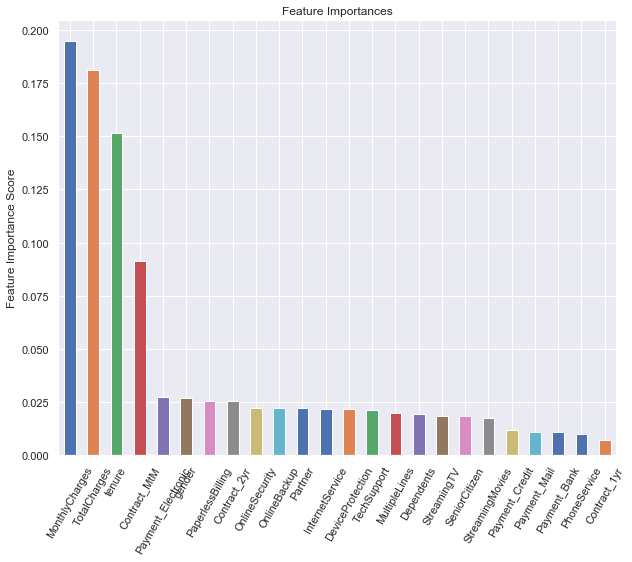

In [98]:
model = RandomForestClassifier(random_state=42)

grid_classifier(model, train, target, feat_imp=True)

#### N_Estimators
I don't want to overfit, so I'll pick a small number for now and max it out after other features are trained.

Seconds to fit: 15.69
Grid Scores: 

{'mean_fit_time': array([0.09605732, 0.15489783, 0.27079635, 0.2295567 , 0.28254356,
       0.30959644, 0.35150924, 0.40231614, 0.43460593, 0.49307876,
       0.51746631, 0.56319547, 0.59283605, 0.63915477, 0.68564234,
       0.74298539, 0.79138417, 0.8103621 , 0.80596008]),
 'mean_score_time': array([0.00867157, 0.01230445, 0.0139976 , 0.01404705, 0.01813116,
       0.01865616, 0.02218742, 0.02459183, 0.0257576 , 0.03161483,
       0.0315063 , 0.03160248, 0.03613615, 0.03790617, 0.04066849,
       0.03970499, 0.04986129, 0.0539948 , 0.04635243]),
 'mean_test_score': array([0.79607635, 0.80612029, 0.81055148, 0.81289937, 0.81514917,
       0.81569944, 0.81758026, 0.8188459 , 0.81981939, 0.82101811,
       0.8213294 , 0.8217809 , 0.82224201, 0.82243358, 0.82286758,
       0.82310505, 0.82318892, 0.82344476, 0.82368849]),
 'mean_train_score': array([0.99879762, 0.99959303, 0.99978188, 0.9998847 , 0.99992403,
       0.99994926, 0.99995918, 0.99996371, 

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

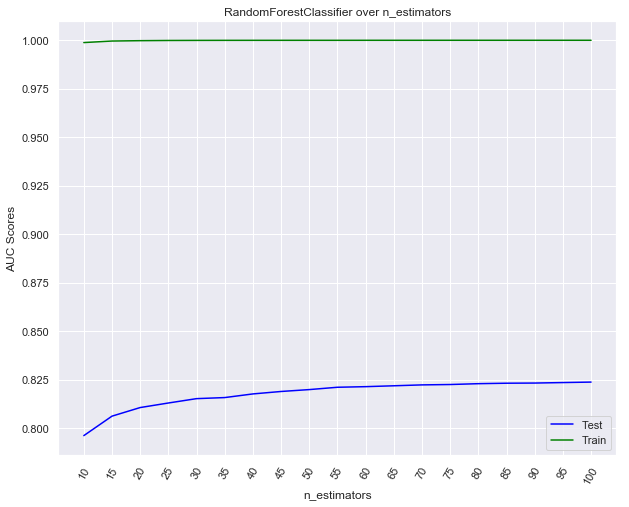

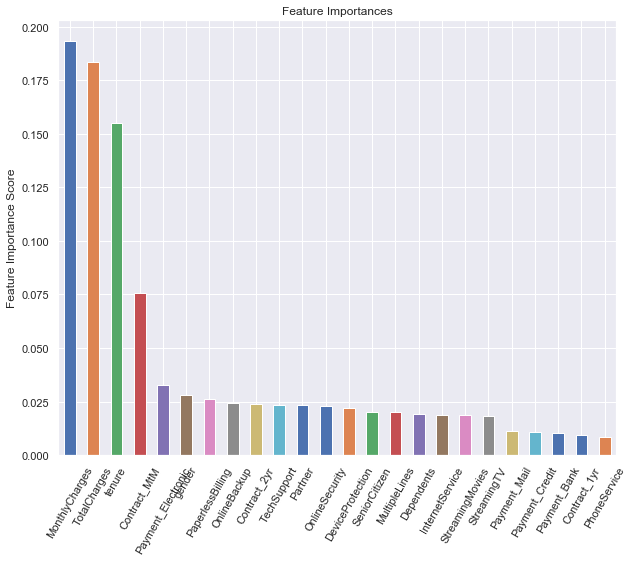

In [100]:
model = RandomForestClassifier(random_state=42)

parameters = {'n_estimators': np.arange(10, 101, 5)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Max Depth

Seconds to fit: 1.72
Grid Scores: 

{'mean_fit_time': array([0.07252092, 0.07460685, 0.12886243, 0.13677521, 0.11525111,
       0.10422354, 0.10159512]),
 'mean_score_time': array([0.00680866, 0.00858221, 0.01512513, 0.0081172 , 0.01109009,
       0.01138172, 0.0079165 ]),
 'mean_test_score': array([0.83058063, 0.83570142, 0.83926243, 0.8416026 , 0.84137864,
       0.84058048, 0.83649278]),
 'mean_train_score': array([0.83585914, 0.84487984, 0.85442931, 0.86601411, 0.88082955,
       0.9006513 , 0.92272714]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3},
            {'max_depth': 4},
            {'max_depth': 5},
            {'max_depth': 6},
            {'max_depth': 7},
            {'max_depth': 8},
            {'max_depth': 9}],
 'rank_test_score': array([7, 6, 4, 1, 2, 3, 5], dtype=int32),
 'split0_test_score': array([0.

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

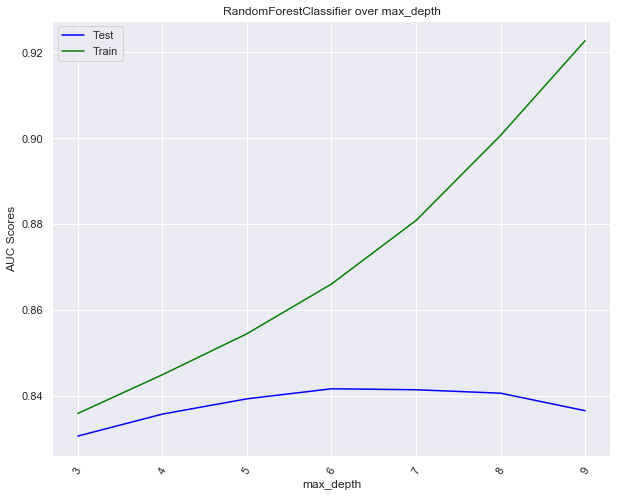

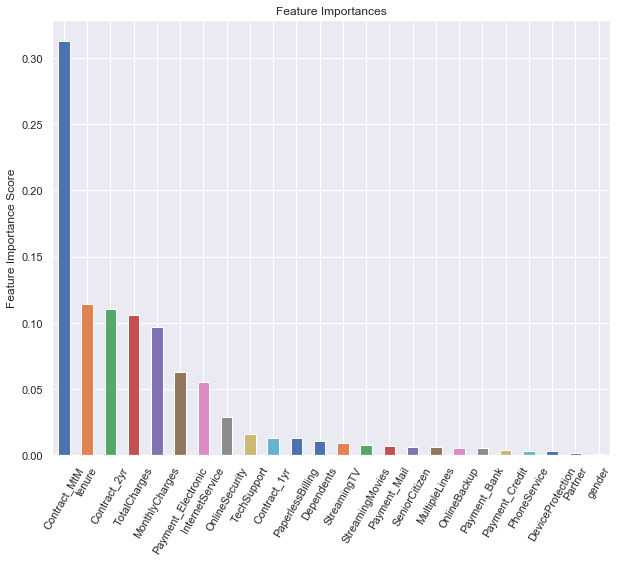

In [101]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=15,
)

parameters = {'max_depth': list(range(3, 10))}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Min Samples Split

In [122]:
np.linspace(2, 20, 10)

array([ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.])

Seconds to fit: 3.77
Grid Scores: 

{'mean_fit_time': array([0.08722005, 0.08486304, 0.082198  , 0.07488046, 0.09452314,
       0.08041301, 0.08018498, 0.0793819 , 0.08533239, 0.08748364,
       0.09024653, 0.07947664, 0.08877683, 0.09285922, 0.10525389,
       0.08837419, 0.08293014, 0.09461989, 0.09876513, 0.07887082,
       0.08050342, 0.07936001, 0.06897607]),
 'mean_score_time': array([0.00865207, 0.00635929, 0.00634408, 0.00595312, 0.00713744,
       0.00707898, 0.01132975, 0.00857019, 0.00637097, 0.00849152,
       0.00786529, 0.00804548, 0.00750952, 0.00808496, 0.00843592,
       0.0070334 , 0.00599599, 0.00895133, 0.00775208, 0.00584517,
       0.00675693, 0.0059073 , 0.00460029]),
 'mean_test_score': array([0.8416026 , 0.84208854, 0.84198251, 0.84214852, 0.84242866,
       0.84221081, 0.84176132, 0.84169394, 0.84163502, 0.84083814,
       0.84083395, 0.84121791, 0.84143472, 0.84076288, 0.84102734,
       0.84131567, 0.84149647, 0.84177297, 0.84226612, 0.84215757,
       0.842

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': range(2, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

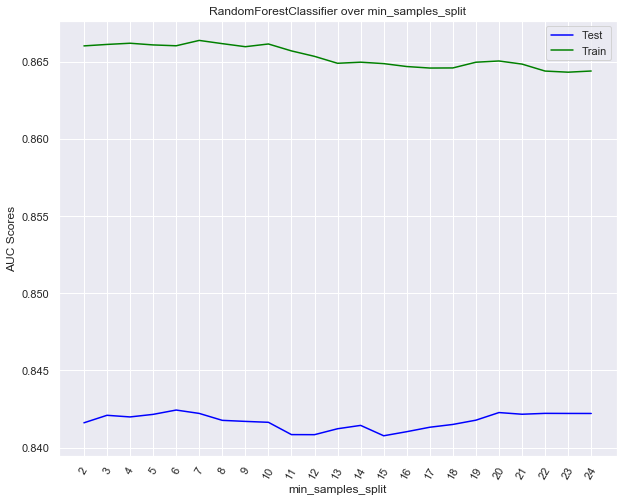

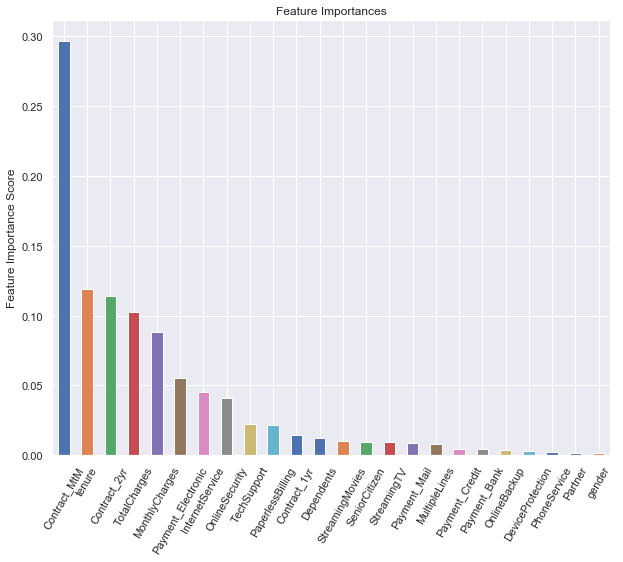

In [126]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=15,
    max_depth=6
)

parameters = {'min_samples_split': range(2, 25)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Min Samples Leaf

Seconds to fit: 3.25
Grid Scores: 

{'mean_fit_time': array([0.0905828 , 0.08700042, 0.08206306, 0.08026495, 0.10032282,
       0.08397064, 0.08654199, 0.079178  , 0.08744779, 0.0834507 ,
       0.08418713, 0.0834362 , 0.08498282, 0.0880815 , 0.07487206,
       0.07831264, 0.08205037, 0.08118606, 0.07669258, 0.06783376]),
 'mean_score_time': array([0.0074964 , 0.00651622, 0.00645704, 0.00690799, 0.00887637,
       0.00733089, 0.00826774, 0.00594945, 0.00629025, 0.00729012,
       0.00909538, 0.00617361, 0.00621147, 0.00613089, 0.00633378,
       0.00596504, 0.00603209, 0.00706434, 0.00621595, 0.00463176]),
 'mean_test_score': array([0.84242866, 0.84270666, 0.84312868, 0.84266665, 0.84227623,
       0.84055308, 0.84055646, 0.84033134, 0.84225948, 0.84223108,
       0.84144082, 0.84247839, 0.84268035, 0.84175002, 0.84189607,
       0.84254468, 0.84253274, 0.84178912, 0.84109515, 0.84204681]),
 'mean_train_score': array([0.86602157, 0.86592184, 0.86521538, 0.86513692, 0.8646233 ,
       0

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': range(1, 21)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

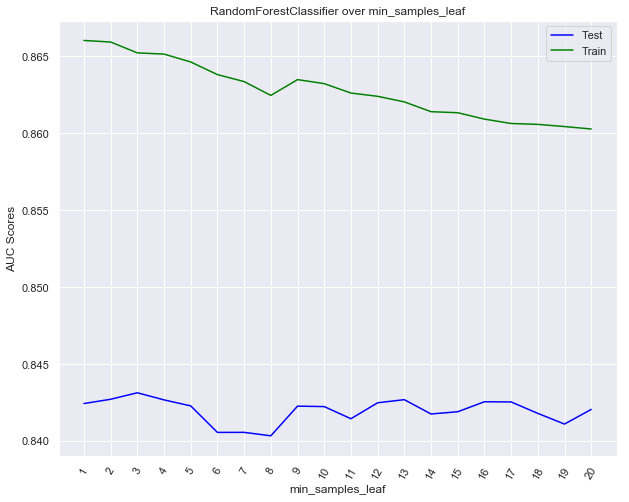

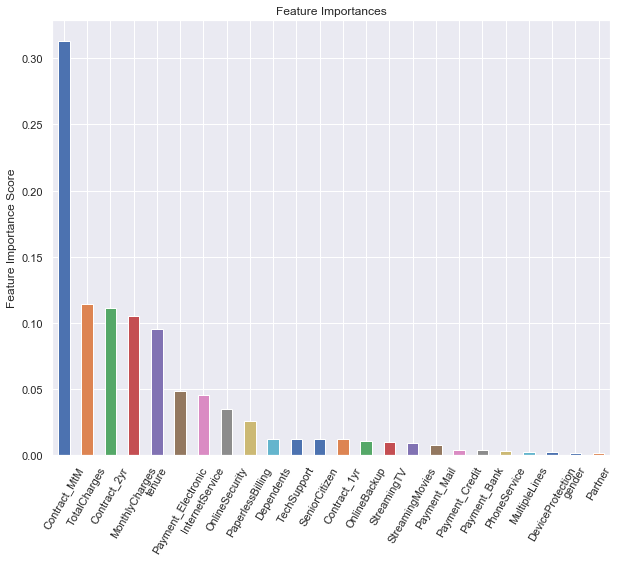

In [127]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=15,
    max_depth=6,
    min_samples_split=6
)

parameters = {'min_samples_leaf': range(1, 21)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Max Features

Seconds to fit: 1.51
Grid Scores: 

{'mean_fit_time': array([0.08252807, 0.08263445, 0.0900074 , 0.10452113, 0.11682334,
       0.11361504, 0.11058149]),
 'mean_score_time': array([0.00844784, 0.00666351, 0.00747261, 0.00709081, 0.00880494,
       0.00861077, 0.00473866]),
 'mean_test_score': array([0.8397672 , 0.84312868, 0.84282756, 0.84229548, 0.84259941,
       0.84147296, 0.8421002 ]),
 'mean_train_score': array([0.86157853, 0.86521538, 0.86679717, 0.86840708, 0.87051435,
       0.8711333 , 0.87268073]),
 'param_max_features': masked_array(data=[3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_features': 3},
            {'max_features': 4},
            {'max_features': 5},
            {'max_features': 6},
            {'max_features': 7},
            {'max_features': 8},
            {'max_features': 9}],
 'rank_test_score': array([7, 1, 2, 4, 3, 6, 5], dtype=int32),
 'split

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': range(3, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

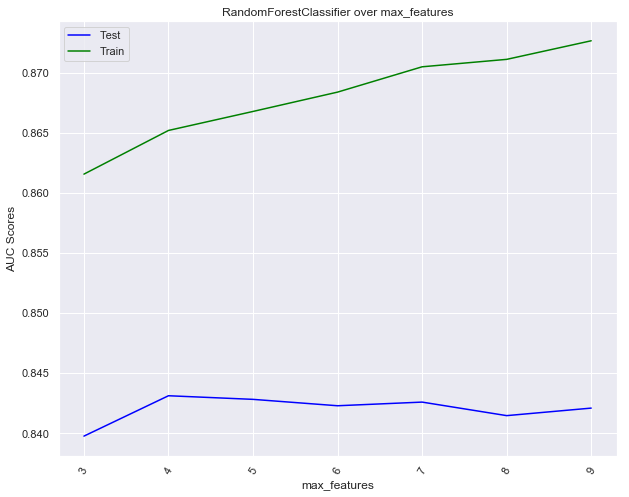

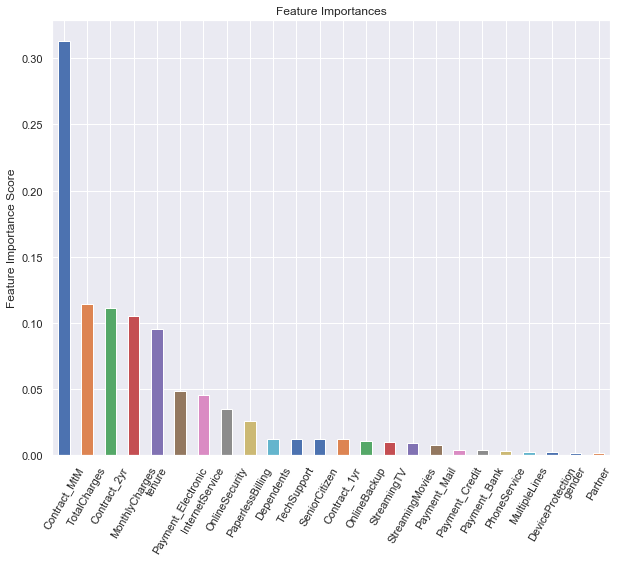

In [129]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=15,
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=3
)

parameters = {'max_features': range(3, 10)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Max out trees

Seconds to fit: 44.79
Grid Scores: 

{'mean_fit_time': array([0.03614802, 0.05891938, 0.11904988, 0.12700481, 0.15962024,
       0.19696298, 0.24460845, 0.39956269, 0.44951701, 0.39135685,
       0.37371359, 0.77711225, 0.92123442, 1.01667695, 0.83307991,
       0.66762643, 0.73610249, 0.62678599, 0.58853717, 0.67044458,
       0.6481111 , 0.66192775, 0.62157364, 0.77057505, 0.75730348,
       0.75447497, 0.78696451, 0.89698567, 1.52480173, 1.41225567,
       0.95762358, 0.88676414, 0.89328403, 0.94647918, 0.96724505,
       1.00250111, 1.03262806, 1.05664458, 1.07768898, 1.02514076]),
 'mean_score_time': array([0.00423584, 0.00548034, 0.00945082, 0.01008086, 0.01082234,
       0.01211591, 0.03080268, 0.03070164, 0.02622437, 0.01962447,
       0.03667545, 0.0578392 , 0.06105762, 0.0576046 , 0.05189762,
       0.05487528, 0.05525723, 0.03718491, 0.030128  , 0.03808131,
       0.04180818, 0.03894091, 0.03868222, 0.04286914, 0.04477124,
       0.04063606, 0.04193201, 0.06310797, 0.0827204

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

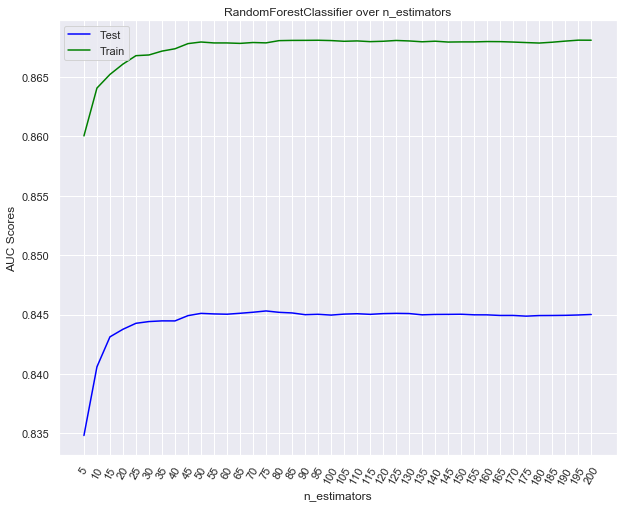

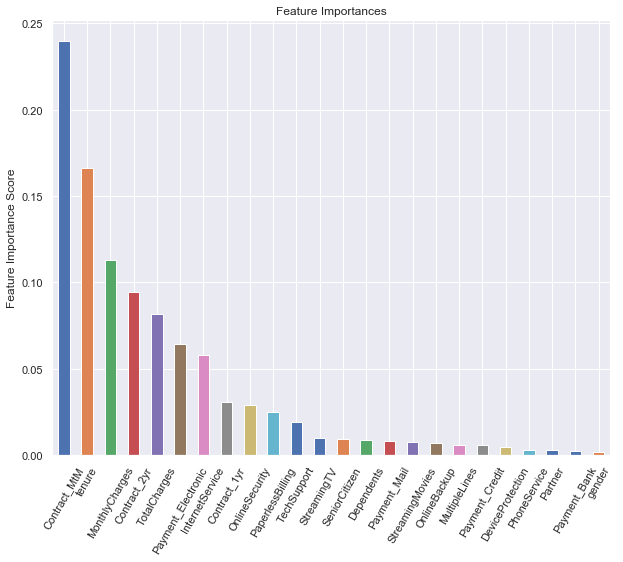

In [130]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=15,
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=3,
    max_features=4
)

parameters = {'n_estimators': np.arange(5, 201, 5)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Final RFC Model

Seconds to fit: 1.10
Grid Scores: 

{'mean_fit_time': array([0.2670084]),
 'mean_score_time': array([0.01827774]),
 'mean_test_score': array([0.84510408]),
 'mean_train_score': array([0.86794509]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85928725]),
 'split0_train_score': array([0.86553891]),
 'split1_test_score': array([0.84999354]),
 'split1_train_score': array([0.86546037]),
 'split2_test_score': array([0.83194993]),
 'split2_train_score': array([0.87163792]),
 'split3_test_score': array([0.84000749]),
 'split3_train_score': array([0.86951124]),
 'split4_test_score': array([0.84428104]),
 'split4_train_score': array([0.86757698]),
 'std_fit_time': array([0.03348258]),
 'std_score_time': array([0.00391959]),
 'std_test_score': array([0.00921817]),
 'std_train_score': array([0.0023744])}
Best Model Parameters: {}
Best Model Score: 0.8451


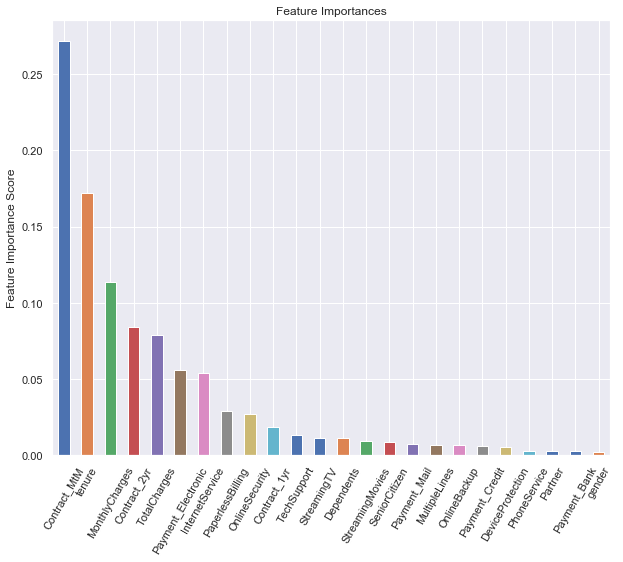

In [180]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=50,
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=3,
    max_features=4
)

rfc_gsearch = grid_classifier(model, train, target, feat_imp=True)